Simons Cat had the most postive tweets: Lots of use of the word 'love'.   CaseyDurkin1 towards the end, lots of words like 'Disguisting'

In [65]:
print get_all_tweets("stephenfry")

0.3578125


# Test 2:  Big Bang Happiness Ranking
Start by making a dataset of the Big Bang Theory tweets

In [1]:
import tweepy 
import pandas as pd

#Twitter API credentials
consumer_key = "HYPwoM8ZUladoXeQYcBjJuNDX"
consumer_secret = "cKOxmurX86oUGdPFXJl4PywRaEl7LCgf8UKFEBpqUdqP0el9Ai"
access_key = "24123781-JqtjluUlYX5SqzlAj94ZExduPrHBfBBPDKqGuoiYw"
access_secret = "B45dS7NzPKHRQljlegUG04uu6ApqaikzbUKRZj6m8Hh4P"
#Twitter only allows access to a users most recent 3240 tweets with this method
     
#authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

#CastList (those that use twitter, anyway)
BangCast = ["kunalnayyar", "simonhelberg","missmayim","MelissaRauch","KevinSussman"]

df = pd.DataFrame()

for screen_name in BangCast:
    ct =0
    new_tweets = api.user_timeline(screen_name = screen_name, count=30, include_rts = False)
    for tweet in new_tweets:
        ct = ct + 1
        twtxt = tweet.text.encode('utf8')
        row=pd.Series([screen_name,tweet.created_at,twtxt],['screen_name', 'post_data', 'tweet_text'])
        #Note to self: this isn't particularly efficient given the additional memory for the copy over. No inplace.
        df = df.append(row,ignore_index=True)
df.to_csv('BangTweets.csv')
        
        


C:\Users\rharg\Anaconda2\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\rharg\Anaconda2\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


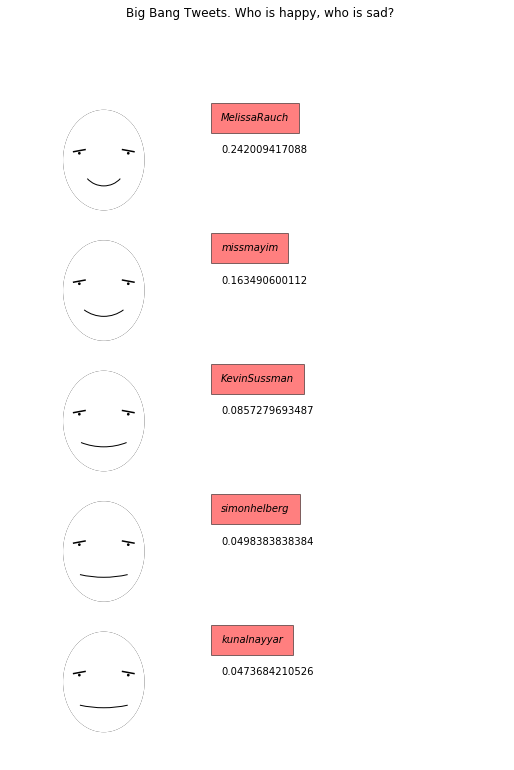

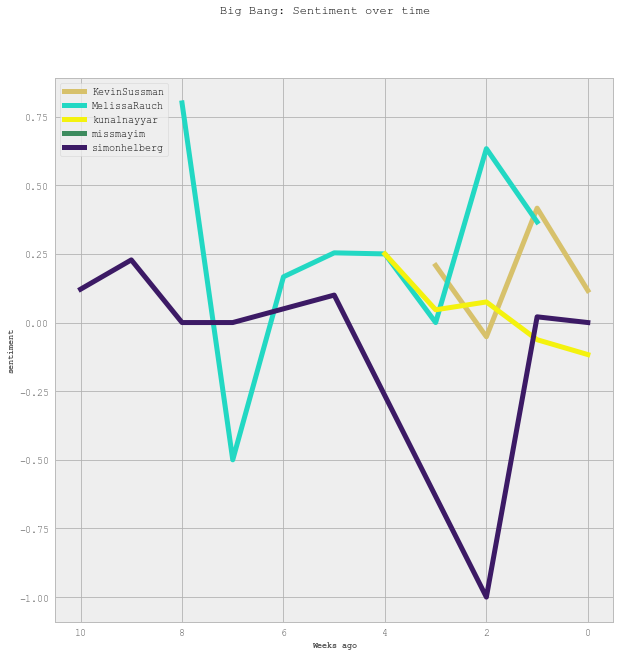

In [2]:
%matplotlib inline
#this last bit is needed here to enable plotting onto Jupyter Notebook
from pylab import *
import pandas as pd
import datetime
from dateutil import relativedelta
from textblob import TextBlob
import re

bd = pd.read_csv('BangTweets.csv', parse_dates=True)
BangCast = ["kunalnayyar", "simonhelberg","missmayim","MelissaRauch","KevinSussman"]

#Convert the datetime to a datetime format then compute the number of weeks from then until now
bd['post_data'] = pd.to_datetime(bd['post_data'])
bd['TimeDelta'] = datetime.datetime.now() - bd.post_data
bd['WksDiff'] = (bd.TimeDelta.dt.days / 7)
bd.WksDiff = bd.WksDiff.astype(int)

#Add a score for sentiment, keep simple acceptin the defaults. Tidy up some unreadable things
def score_tweets(tx):
    temp = tx
    temp = re.sub(r'[^\x00-\x7f]',r'', temp) 
    temp = re.sub(r'https?:\/\/.*\/[a-zA-Z0-9]*', '', temp)
    temp = re.sub(r'@[a-zA-Z0-9]*', '', temp)
    temp = re.sub(r'\$[a-zA-Z0-9]*', '', temp)
    temp = re.sub(r'[0-9]*','',temp)
    tx = temp
    analysis = TextBlob(tx)
    snt = analysis.sentiment.polarity
    return snt

bd['snt'] = bd['tweet_text'].apply(score_tweets)

#Data should go back 10 weeks, set up a new dataframe to receive this data
BackTo = max(bd.WksDiff)

#Summarise the data, converting back to a dataframe
group = bd['snt'].groupby(bd['screen_name']).mean()
bd_agg = group.to_frame().reset_index()
bd_agg = bd_agg.rename(columns= {0: 'screen_name'})
bd_agg.index.name = 'index'
bd_agg.sort_values(by=['snt'], ascending= False, inplace=True)

def Twitface(ax, smcu):
    # face outline, cover over overlaps with white
    f = mpl.patches.Ellipse( (0,-0.025), 1.5, 1.85, fc='black', linewidth=6)
    ax.add_artist(f)
    f = mpl.patches.Ellipse( (0,-0.025), 1.5, 1.85, fc='white', ec='none')
    ax.add_artist(f)

    # mouth arc
    smcu = (smcu+.001) * 5
    smwi = 0.9
    if smcu < 0:
        smwi = -0.9
    sm = mpl.patches.Arc( (0,-.5+.5/smcu), 1/smcu, 1/smcu, theta1=270-180/pi*arctan(smcu*smwi), 
                         theta2=270+180/pi*arctan(smcu*smwi),facecolor='black',edgecolor='black')
    ax.add_artist(sm)

    # eyes
    e = mpl.patches.Ellipse( (-0.45, 0.1), .05, .05, facecolor='black',)
    ax.add_artist(e)
    e = mpl.patches.Ellipse( (0.45, 0.1), .05, .05, facecolor='black')
    ax.add_artist(e)

    # draw eyebrows
    plot([-0.555,-0.345],[0.128875,0.167375],'black')
    plot([0.555,0.345],[0.128875,0.167375],'black')

def TwitfaceDesc(ax, smcu,psn):
    text(-4, 0.7, psn, style='italic', bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    text(-4, 0.1,smcu)

#Plot some faces such that the smile is proportional to the sentiment score
fig = figure(figsize=(12,12))
for i in range(5): 
    ax = fig.add_subplot(5,2,(i*2)+1 ,aspect='equal')
    Twitface(ax, bd_agg.iloc[i,1])
    ax.axis([-1.2,1.2,-1.2,1.2])
    ax.axis('off')
    ax = fig.add_subplot(5,2,(i*2)+2 ,aspect='equal')
    TwitfaceDesc(ax, bd_agg.iloc[i,1],bd_agg.iloc[i,0])
    ax.axis([-1.2,1.2,-1.2,1.2])
    ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Big Bang Tweets. Who is happy, who is sad?')
fig.show()    

#summarise by person by week

g2 = bd.groupby(['screen_name', 'WksDiff'], as_index=False).mean()
groups = g2.groupby('screen_name')

plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')


fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.WksDiff  , group.snt,  label=name, linewidth=5)
ax.legend(numpoints=1, loc='upper left')
plt.xlabel('Weeks ago', weight='bold', size='small')
plt.ylabel('sentiment', weight='bold', size='small')
ax.invert_xaxis()
fig.suptitle('Big Bang: Sentiment over time')

plt.show()